# __Movie Recommendation System__

In [1249]:
import pandas as pd
import numpy as np
import re
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import text_preprocessing as tp
import utils
import spacy

from nltk.corpus import stopwords
from nltk.corpus import words
from flashtext import KeywordProcessor
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


warnings.filterwarnings("ignore")

## Importing Dataset for Movie Metadata

Use the IMDB dataset containing information about movies. Two different data sources will be utilized in the process of traning the model.

__a. Data Source:__ https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/

In [1250]:
# Open file containing movie metadata
movies_metadata_df = pd.read_csv("./dataset/movies_metadata.csv")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,10/30/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,12/15/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,12/22/1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,12/22/1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,2/10/1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [1251]:
# Open file containing the movie credits, i.e. casts and crews
movies_credits_df = pd.read_csv("./dataset/credits.csv")
movies_credits_df.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [1252]:
# Combine the dataframes of movie metadata and credits
movies_metadata_df = pd.merge(movies_metadata_df, movies_credits_df, on=["id"], how="left")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [1253]:
# List all the columns in movie metadata's dataframe
movies_metadata_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew'],
      dtype='object')

In [1254]:
# Drop columns that are not relevant
del_columns = ['belongs_to_collection', 'homepage', 'id', 'original_language', 'original_title', 'popularity', 'poster_path', 
               'adult', 'tagline', 'production_countries', 'spoken_languages', 'status', 'video', 'vote_count', 'overview']
movies_metadata_df = movies_metadata_df.drop(del_columns, axis=1)

# Remove 'tt' appended on the IMDB ID
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].apply(lambda x : x[2:] if isinstance(x, str) and "tt" in x else x)

movies_metadata_df.head(5)

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,vote_average,cast,crew
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",0114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,Toy Story,7.7,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,104.0,Jumanji,6.9,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0113228,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",12/22/1995,0.0,101.0,Grumpier Old Men,6.5,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0114885,[{'name': 'Twentieth Century Fox Film Corporat...,12/22/1995,81452156.0,127.0,Waiting to Exhale,6.1,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,0,"[{'id': 35, 'name': 'Comedy'}]",0113041,"[{'name': 'Sandollar Productions', 'id': 5842}...",2/10/1995,76578911.0,106.0,Father of the Bride Part II,5.7,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


__b. Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [1255]:
# Open another file containing the movie metadata
movies_df = pd.read_csv("./dataset/movies.csv")
movies_df.head(5)

,imdbId,Imdb Link,Title,IMDB Score,Genre,local_image_path
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation;Adventure;Comedy,images/114709_.jpg
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action;Adventure;Family,images/113497_.jpg
2,113277,http://www.imdb.com/title/tt113277,Heat (1995),8.2,Action;Crime;Drama,images/113277_.jpg
3,114319,http://www.imdb.com/title/tt114319,Sabrina (1995),6.3,Comedy;Drama,images/114319_.jpg
4,114576,http://www.imdb.com/title/tt114576,Sudden Death (1995),5.7,Action;Crime;Thriller,images/114576_.jpg


In [1256]:
# Rename the column names of movies info by removing the spaces and converting to lower case
movies_df = movies_df.rename(columns={"imdbId" : "imdb_id", "Imdb Link" : "imbd_link", "Title" : "movie", "IMDB Score" : "imdb_score", "Genre" : "genre"})
print(movies_df.columns)

Index(['imdb_id', 'imbd_link', 'movie', 'imdb_score', 'genre',
       'local_image_path'],
      dtype='object')


In [1257]:
# Drop columns that are not relevant
del_columns = ['imbd_link', 'imdb_score', 'local_image_path']

movies_df = movies_df.drop(columns=del_columns, axis=1)
movies_df.head(5)

,imdb_id,movie,genre
0,114709,Toy Story (1995),Animation;Adventure;Comedy
1,113497,Jumanji (1995),Action;Adventure;Family
2,113277,Heat (1995),Action;Crime;Drama
3,114319,Sabrina (1995),Comedy;Drama
4,114576,Sudden Death (1995),Action;Crime;Thriller


In [1258]:
# Merge two different datasets for movies metadata

movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].fillna(0) # fixed errors on NaN values when converting to int data type
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].astype(int)

movies_metadata_df = pd.merge(movies_metadata_df, movies_df, on=["imdb_id"], how="right")
movies_metadata_df.head(5)

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,vote_average,cast,crew,movie,genre
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,Toy Story,7.7,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",Toy Story (1995),Animation;Adventure;Comedy
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,104.0,Jumanji,6.9,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",Jumanji (1995),Action;Adventure;Family
2,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",113277,"[{'name': 'Regency Enterprises', 'id': 508}, {...",12/15/1995,187436818.0,170.0,Heat,7.7,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",Heat (1995),Action;Crime;Drama
3,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",114319,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",12/15/1995,0.0,127.0,Sabrina,6.2,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",Sabrina (1995),Comedy;Drama
4,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",114576,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",12/22/1995,64350171.0,106.0,Sudden Death,5.5,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",Sudden Death (1995),Action;Crime;Thriller


## Importing Dataset for Movie Reviews

Use the IMDB dataset for movie reviews.

__Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [1259]:
# Open the file containing the movie reviews
reviews_df = pd.read_csv("./dataset/reviews.csv")
reviews_df.head(5)

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,roberta_sentiment
0,rw0213367,SUPERNOVA HEIGHTS,A Nightmare on Elm Street (1984),8.0,A Classic of the horror films History,27 August 2003,0,This is the beginning of a great horror film s...,"['0', '0']",Positive
1,rw0213369,kibler@adelphia.net,A Nightmare on Elm Street (1984),NaN,Better than your average horror movie,1 September 2003,0,"Nightmare on Elm Street, A (1984) John Saxon, ...","['0', '0']",Negative
2,rw0213371,matthew87,A Nightmare on Elm Street (1984),NaN,good slasher flick,1 September 2003,0,"the best freddy film period,1 because the horr...","['0', '0']",Strongly Positive
3,rw0213375,rossrobinson,A Nightmare on Elm Street (1984),10.0,A nightmare on elm st part 1,27 September 2003,0,I remember seeing a nightmare on elm street pa...,"['0', '2']",Negative
4,rw0213376,Andres24,A Nightmare on Elm Street (1984),9.0,Highway to hell,3 October 2003,0,"It's a nightmare. If Nancy falls asleep, they...","['1', '1']",Positive


In [1260]:
# Merge the movie metadata (from the same kaggle source) and reviews
movie_reviews_df = pd.merge(movies_df, reviews_df, on=["movie"], how="inner")
movie_reviews_df.head(5)

,imdb_id,movie,genre,review_id,reviewer,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,roberta_sentiment
0,114709,Toy Story (1995),Animation;Adventure;Comedy,rw1223346,KUAlum26,10.0,Can it be ten years already?,23 November 2005,0,PIXAR animation was but an experimental animat...,"['1', '1']",Positive
1,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3110243,MUFCOK,10.0,A childhood favourite,24 October 2014,0,Toy Story is one of those movies which holds a...,"['1', '2']",Strongly Positive
2,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3109622,Rainey-Dawn,6.0,Not As Good As I Was Hoping,23 October 2014,0,"This is another one of my ""I should like this ...","['2', '8']",Neutral
3,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3124846,byson5186,9.0,Why The First Toy Story Is My Favorite,15 November 2014,0,So far they have come out with 3 Toy Story mov...,"['0', '1']",Positive
4,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3635799,snperera,9.0,A classic friendship story!,8 February 2017,0,"Wow, well what can I say! This is a favorite o...","['0', '1']",Strongly Positive


In [1261]:
# Drop columns that are not relevant, including the movie and genre. IMDB ID can be used to associate 
# review records with movie metadata
del_columns = ['movie', 'genre', 'review_id', 'reviewer', 'spoiler_tag', 'helpful']

movie_reviews_df = movie_reviews_df.drop(columns=del_columns, axis=1)
movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_date,review_detail,roberta_sentiment
0,114709,10.0,Can it be ten years already?,23 November 2005,PIXAR animation was but an experimental animat...,Positive
1,114709,10.0,A childhood favourite,24 October 2014,Toy Story is one of those movies which holds a...,Strongly Positive
2,114709,6.0,Not As Good As I Was Hoping,23 October 2014,"This is another one of my ""I should like this ...",Neutral
3,114709,9.0,Why The First Toy Story Is My Favorite,15 November 2014,So far they have come out with 3 Toy Story mov...,Positive
4,114709,9.0,A classic friendship story!,8 February 2017,"Wow, well what can I say! This is a favorite o...",Strongly Positive


## Exploratory Data Analysis

Check and resolve duplicate records

In [1262]:
# Drop duplicate records in movies metadata
print(f"Record count before removing duplicates => {movies_metadata_df.shape[0]}")
movies_metadata_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movies_metadata_df.shape[0]}")

Record count before removing duplicates => 4174
Record count after removing duplicates  => 4071


In [1263]:
# Drop duplicate records in movies reviews
print(f"Record count before removing duplicates => {movie_reviews_df.shape[0]}")
movie_reviews_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movie_reviews_df.shape[0]}")

Record count before removing duplicates => 557580
Record count after removing duplicates  => 542632


Check and resolve missing values for `movie metadata`

In [1264]:
# Check for missing values in movies metadata
movies_metadata_df.isna().sum()

budget                  3
genres                  3
imdb_id                 0
production_companies    3
release_date            3
revenue                 3
runtime                 3
title                   3
vote_average            3
cast                    3
crew                    3
movie                   0
genre                   0
dtype: int64

In [1265]:
# List of movies with missing information
movies_metadata_df[movies_metadata_df['title'].isna()]

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,vote_average,cast,crew,movie,genre
2780,NaN,NaN,462322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grindhouse (2007),Action;Horror;Thriller
3521,NaN,NaN,448694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puss in Boots (2011),Animation;Action;Adventure
3793,NaN,NaN,1937390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nymphomaniac: Vol. I (2013),Drama


In [1266]:
# Drop all movies with missing information
movies_metadata_df.dropna(inplace=True, axis=0)
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4068 entries, 0 to 4173
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4068 non-null   float64
 1   genres                4068 non-null   object 
 2   imdb_id               4068 non-null   int64  
 3   production_companies  4068 non-null   object 
 4   release_date          4068 non-null   object 
 5   revenue               4068 non-null   float64
 6   runtime               4068 non-null   float64
 7   title                 4068 non-null   object 
 8   vote_average          4068 non-null   float64
 9   cast                  4068 non-null   object 
 10  crew                  4068 non-null   object 
 11  movie                 4068 non-null   object 
 12  genre                 4068 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 444.9+ KB


Check and resolve missing values for `movie reviews`

In [1267]:
# Check for missing values in movies reviews
movie_reviews_df.isna().sum()

imdb_id                  0
rating               76869
review_summary           1
review_date              0
review_detail            0
roberta_sentiment        0
dtype: int64

In [1268]:
# Replace all missing values in review summary and detail with a blank
movie_reviews_df[['review_summary', 'review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].fillna('')
movie_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542632 entries, 0 to 557579
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   imdb_id            542632 non-null  int64  
 1   rating             465763 non-null  float64
 2   review_summary     542632 non-null  object 
 3   review_date        542632 non-null  object 
 4   review_detail      542632 non-null  object 
 5   roberta_sentiment  542632 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 29.0+ MB


In [1269]:
# Define a mapping for sentiment to rating
sentiment_to_rating = {
    'Strongly Positive' : 1,
    'Positive': 8,
    'Neutral': 5,
    'Negative': 2,
    'Strongly Negative': 10
}

# Fill null values in the 'rating' column based on the 'sentiment' column
movie_reviews_df['rating'].fillna(movie_reviews_df['roberta_sentiment'].map(sentiment_to_rating), inplace=True)

# Convert the ratings to integer type
movie_reviews_df['rating'] = movie_reviews_df['rating'].astype(int)
movie_reviews_df['rating'].info()

<class 'pandas.core.series.Series'>
Int64Index: 542632 entries, 0 to 557579
Series name: rating
Non-Null Count   Dtype
--------------   -----
542632 non-null  int32
dtypes: int32(1)
memory usage: 6.2 MB


#### __Data Wrangling and Visualizations__:

Conduct data wrangling on `movie metadata` to transform and structure data into a desired format

In [1270]:
# Separate movie release year from the title
pattern_year = r'\((\d{4})\)$'
movies_metadata_df['release_year'] = movies_metadata_df['movie'].str.extract(pattern_year).astype(int)
movies_metadata_df['movie'] = movies_metadata_df['movie'].str.replace(pattern_year, '', regex=True).str.strip()
movies_metadata_df[['movie', 'release_year']].head(5)

# Drop columns containing duplicate movie information
dup_columns = ['genres', 'release_date', 'title']
movies_metadata_df = movies_metadata_df.drop(columns=dup_columns, axis=1)

# Rename the 'movie' to 'title'
movies_metadata_df = movies_metadata_df.rename(columns={'movie': 'title'})

movies_metadata_df.head(5)

,budget,imdb_id,production_companies,revenue,runtime,vote_average,cast,crew,title,genre,release_year
0,30000000.0,114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",373554033.0,81.0,7.7,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",Toy Story,Animation;Adventure;Comedy,1995
1,65000000.0,113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",262797249.0,104.0,6.9,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",Jumanji,Action;Adventure;Family,1995
2,60000000.0,113277,"[{'name': 'Regency Enterprises', 'id': 508}, {...",187436818.0,170.0,7.7,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",Heat,Action;Crime;Drama,1995
3,58000000.0,114319,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",0.0,127.0,6.2,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",Sabrina,Comedy;Drama,1995
4,35000000.0,114576,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",64350171.0,106.0,5.5,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",Sudden Death,Action;Crime;Thriller,1995


We will exclusively examine documents that have been made public after 1990.

In [1271]:
# Convert genre into list data type
movies_metadata_df['genre'] = movies_metadata_df['genre'].apply(lambda x : x.split(";"))

# Convert to a list of production companies
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda x : utils.convert_str_to_dict(x, ['name']))
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda list_of_dicts : [value for d in list_of_dicts for value in d.values()])

# TODO: Need to fix the issue on cast and crew with names containing single quotation
pattern_director = r"'job': 'Director', 'name': '([^']*)'"
movies_metadata_df['director'] = movies_metadata_df['crew'].apply(lambda x : re.findall(pattern_director, x) )

pattern_casts = r"'name': '([^']*)'"
movies_metadata_df['cast'] = movies_metadata_df['cast'].apply(lambda x : re.findall(pattern_casts, x) )

# Drop the column for crew
movies_metadata_df = movies_metadata_df.drop(columns=['crew'], axis=1)

# Rearrange the order of columns
desired_order = ['imdb_id', 'title', 'release_year', 'genre', 'production_companies', 'cast', 'director', 'budget', 'revenue', 'runtime', 'vote_average',]
movies_metadata_df = movies_metadata_df[desired_order]

movies_metadata_df[['genre', 'production_companies', 'cast', 'director']].head(5)

,genre,production_companies,cast,director
0,"[Animation, Adventure, Comedy]",[Pixar Animation Studios],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[John Lasseter]
1,"[Action, Adventure, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",[Joe Johnston]
2,"[Action, Crime, Drama]","[Regency Enterprises, Forward Pass, Warner Bros.]","[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...",[Michael Mann]
3,"[Comedy, Drama]","[Paramount Pictures, Scott Rudin Productions, ...","[Harrison Ford, Julia Ormond, Greg Kinnear, An...",[Sydney Pollack]
4,"[Action, Crime, Thriller]","[Universal Pictures, Imperial Entertainment, S...","[Jean-Claude Van Damme, Powers Boothe, Dorian ...",[Peter Hyams]


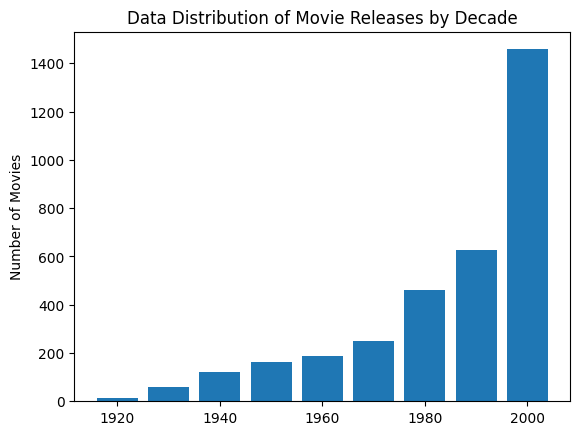

In [1272]:
# Data distribution of movie releases by decade
movie_release_years = movies_metadata_df['release_year']

decades = np.arange(1920, 2020, 10)
decade_counts, _ = np.histogram(movie_release_years, bins=decades)

plt.bar(decades[:-1], decade_counts, width=8)
plt.ylabel('Number of Movies')
plt.title('Data Distribution of Movie Releases by Decade')
plt.show()


In [1273]:
# Keep only films that were released from the year 1935 onward
movies_metadata_df = movies_metadata_df[movies_metadata_df['release_year'] >= 1935]
print(f"Shape of the dataset: {movies_metadata_df.shape}")

Shape of the dataset: (4026, 11)


In [1274]:
# Combine 'positive' and 'strongly positive' reviews, and 'negative' and 'strongly negative' reciews
movie_reviews_df['roberta_sentiment'] = movie_reviews_df['roberta_sentiment'].replace('Strongly Positive', 'Positive')
movie_reviews_df['roberta_sentiment'] = movie_reviews_df['roberta_sentiment'].replace('Strongly Negative', 'Negative')
movie_reviews_df['roberta_sentiment'].value_counts().unique

<bound method Series.unique of Positive    257636
Neutral     161133
Negative    123863
Name: roberta_sentiment, dtype: int64>

Perform additional analysis of the data and create visual representations to gain a better understanding of the movie metadata and reviews. This information provides insights on trends and patterns in the movie data, which might be important especially on the reports that will be provided to the client.

In [1275]:
# Show statistical summary of movie metadata and reviews
pd.merge(movies_metadata_df, movie_reviews_df, on=["imdb_id"], how="inner").describe()

,imdb_id,release_year,budget,revenue,runtime,vote_average,rating
count,5.379890e+05,537989.000000,5.379890e+05,5.379890e+05,537989.000000,537989.000000,537989.000000
mean,5.698202e+05,1996.376108,4.244408e+07,1.563441e+08,112.683248,6.607103,6.626686
std,7.672910e+05,17.320267,5.348892e+07,2.483693e+08,22.214416,0.851621,2.535446
min,2.666300e+04,1935.000000,0.000000e+00,0.000000e+00,0.000000,1.600000,1.000000
25%,9.721600e+04,1989.000000,3.900000e+06,1.100000e+07,97.000000,6.100000,5.000000
50%,2.597110e+05,2002.000000,2.200000e+07,6.354178e+07,109.000000,6.700000,7.000000
75%,7.805210e+05,2008.000000,6.000000e+07,1.881333e+08,124.000000,7.200000,8.000000
max,5.247022e+06,2017.000000,3.800000e+08,2.787965e+09,254.000000,8.300000,10.000000


Tally the number of reviews categorized by customer ratings ranging from 1 (lowest) to 10 (highest) to gauge the overall sentiment of the dataset based on these ratings. Get the frequency for each review sentiment as well, which was based from RoBERTa.

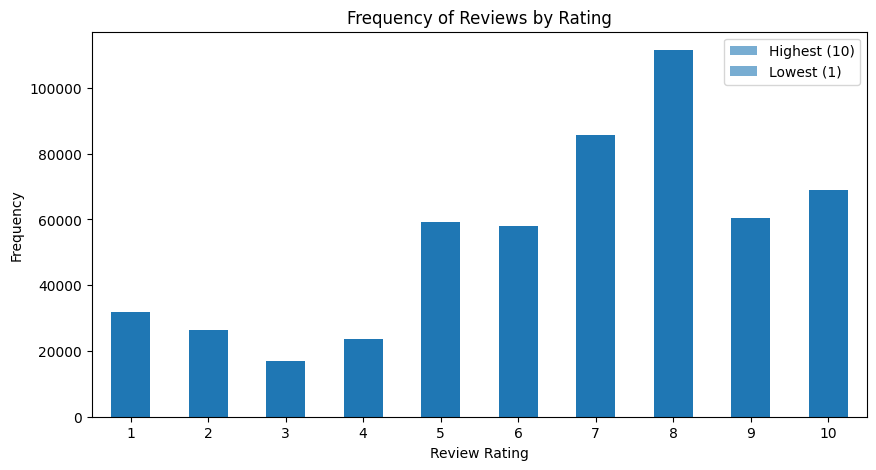

In [1276]:
# Count the reviews based on customer ratings
rating_counts = movie_reviews_df['rating'].value_counts().sort_index()
ax = rating_counts.plot(kind='bar', title='Frequency of Reviews by Rating', figsize=(10, 5))

ax.set_xlabel('Review Rating')
ax.set_ylabel('Frequency')

# Add a custom legend indicating 10 as highest and 1 as lowest
legend_labels = {10: 'Highest (10)', 1: 'Lowest (1)'}
legend_handles = [plt.Rectangle((0, 0), 1, 1, alpha=0.6, label=label) for rating, label in legend_labels.items()]

ax.legend(handles=legend_handles, labels=legend_labels.values(), loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

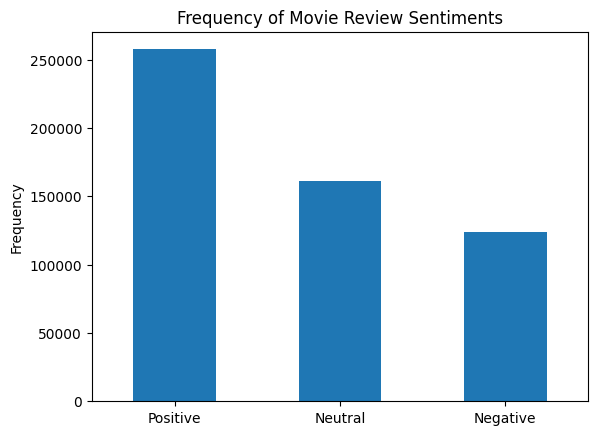

In [1277]:
# Get the frequency of values in the 'roberta_sentiment' column
sentiment_counts = movie_reviews_df['roberta_sentiment'].value_counts()
sentiment_counts.plot(kind='bar')

plt.ylabel('Frequency')
plt.title('Frequency of Movie Review Sentiments')
plt.xticks(rotation=0)
plt.show()

#### __For Feature Selection and Engineering__:

Convert the 'roberta_sentiment' feature into a numeric format where Negative is represented as 0, Neutral as 1, and Positive as 2

In [1278]:
encoder = LabelEncoder()
movie_reviews_df['roberta_sentiment_encoded'] = encoder.fit_transform(movie_reviews_df['roberta_sentiment'])
movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_date,review_detail,roberta_sentiment,roberta_sentiment_encoded
0,114709,10,Can it be ten years already?,23 November 2005,PIXAR animation was but an experimental animat...,Positive,2
1,114709,10,A childhood favourite,24 October 2014,Toy Story is one of those movies which holds a...,Positive,2
2,114709,6,Not As Good As I Was Hoping,23 October 2014,"This is another one of my ""I should like this ...",Neutral,1
3,114709,9,Why The First Toy Story Is My Favorite,15 November 2014,So far they have come out with 3 Toy Story mov...,Positive,2
4,114709,9,A classic friendship story!,8 February 2017,"Wow, well what can I say! This is a favorite o...",Positive,2


In [1279]:
# Group the review records by movie ID, then calculate the median sentiment score for each ID
review_sentiment_median_scores = movie_reviews_df.groupby('imdb_id')['roberta_sentiment_encoded'].median().reset_index()
review_sentiment_median_scores.head(5)

,imdb_id,roberta_sentiment_encoded
0,417,2.0
1,439,2.0
2,4972,1.0
3,10323,1.0
4,12349,2.0


In [1280]:
# Add in the movie metadata dataframe the sentiment score
movies_metadata_df = pd.merge(movies_metadata_df, review_sentiment_median_scores, on=["imdb_id"], how="inner")

# Replace values in the 'sentiments' column
movies_metadata_df['viwers_sentiment'] = movies_metadata_df['roberta_sentiment_encoded'].replace({0: 'negative', 1: 'neutral', 2: 'positive'})

movies_metadata_df.head(5)

,imdb_id,title,release_year,genre,production_companies,cast,director,budget,revenue,runtime,vote_average,roberta_sentiment_encoded,viwers_sentiment
0,114709,Toy Story,1995,"[Animation, Adventure, Comedy]",[Pixar Animation Studios],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[John Lasseter],30000000.0,373554033.0,81.0,7.7,2.0,positive
1,113497,Jumanji,1995,"[Action, Adventure, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",[Joe Johnston],65000000.0,262797249.0,104.0,6.9,2.0,positive
2,113277,Heat,1995,"[Action, Crime, Drama]","[Regency Enterprises, Forward Pass, Warner Bros.]","[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...",[Michael Mann],60000000.0,187436818.0,170.0,7.7,2.0,positive
3,114319,Sabrina,1995,"[Comedy, Drama]","[Paramount Pictures, Scott Rudin Productions, ...","[Harrison Ford, Julia Ormond, Greg Kinnear, An...",[Sydney Pollack],58000000.0,0.0,127.0,6.2,2.0,positive
4,114576,Sudden Death,1995,"[Action, Crime, Thriller]","[Universal Pictures, Imperial Entertainment, S...","[Jean-Claude Van Damme, Powers Boothe, Dorian ...",[Peter Hyams],35000000.0,64350171.0,106.0,5.5,1.0,neutral


In [1281]:
# Transform the 'genre' column to binary encoded genres
mlb_genre = MultiLabelBinarizer()
genre_features = pd.DataFrame(mlb_genre.fit_transform(movies_metadata_df['genre'].apply(lambda x: x)), columns=mlb_genre.classes_)

print(f"Shape of dataset: {genre_features.shape}")
genre_features.head(5)

Shape of dataset: (4026, 24)


,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


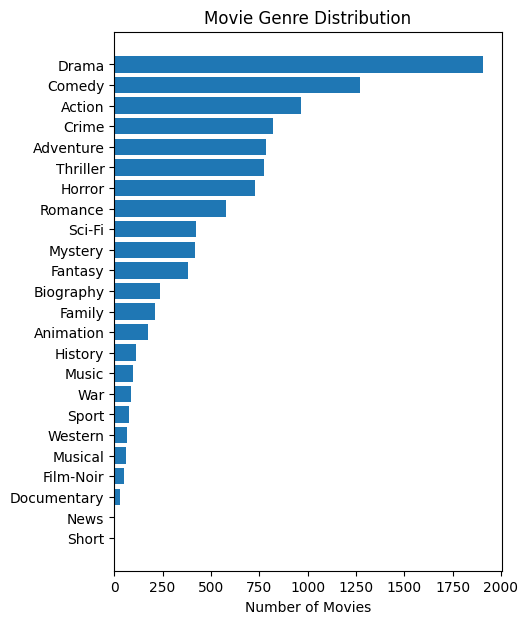

In [1282]:
genre_counts = np.sum(genre_features, axis=0)
genre_features_df = pd.DataFrame({'genre': genre_features.columns.to_list(), 'count': genre_counts}).sort_values(by="count")
genre_features_df = genre_features_df.reset_index(drop=True)

plt.figure(figsize=(5, 7))
plt.barh(genre_features_df['genre'], genre_features_df['count'])
plt.xlabel('Number of Movies')
plt.title('Movie Genre Distribution')
plt.show()

In [1283]:
# Drop the 'News' and 'Short' movie genre
genre_features = genre_features.drop(columns=['News', 'Short'], axis=1)
print(f"Shape of dataset: {genre_features.shape}")

Shape of dataset: (4026, 22)


In [1284]:
# Transform the 'directors' column to binary encoded directors
mlb_cast = MultiLabelBinarizer()
cast_features = pd.DataFrame(mlb_cast.fit_transform(movies_metadata_df['cast'].apply(lambda x: x)), columns=mlb_cast.classes_)

print(f"Shape of dataset: {cast_features.shape}")
cast_features.head(5)

Shape of dataset: (4026, 51741)


,"""Weird Al"" Yankovic",50 Cent,A Martinez,A. Frank Ruffo,A. J. Benza,A. J. Langer,A. Jay Radcliff,A. Madeline Smith,A. Michael Baldwin,A. P. Singh,...,Патрик О’Нил,Рашад Эванс,Том Ву,Шэрин Митчелл,Эрика Элениак,Юлия Снигирь,پیمان معادی,杰森·莫玛,松田龙平,高桥一生
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


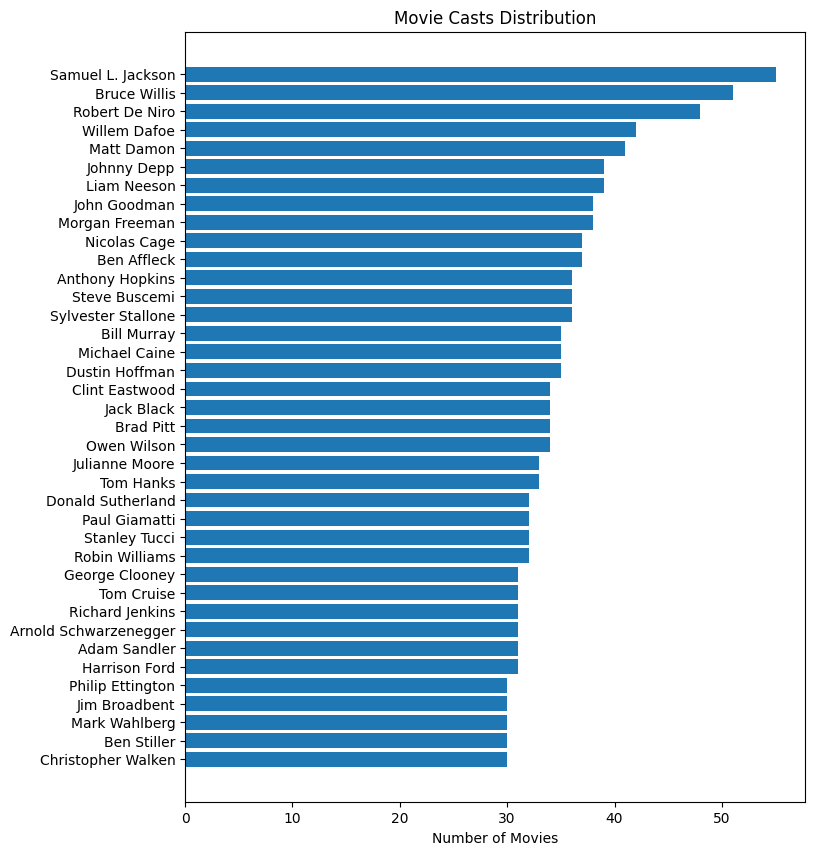

In [1285]:
cast_counts = np.sum(cast_features, axis=0)
cast_features_df = pd.DataFrame({'cast': cast_features.columns.to_list(), 'count': cast_counts}).sort_values(by="count")
cast_features_df = cast_features_df[cast_features_df['count'] >= 30]
cast_features_df = cast_features_df.reset_index(drop=True)

plt.figure(figsize=(8, 10))
plt.barh(cast_features_df['cast'], cast_features_df['count'])
plt.xlabel('Number of Movies')
plt.title('Movie Casts Distribution')
plt.show()

In [1286]:
# Retain only casts with 30 or more movies
cast_features = cast_features[cast_features_df['cast']]
print(f"Shape of dataset: {cast_features.shape}")

Shape of dataset: (4026, 38)


In [1287]:
# Transform the 'directors' column to binary encoded directors
mlb_director = MultiLabelBinarizer()
director_features = pd.DataFrame(mlb_director.fit_transform(movies_metadata_df['director'].apply(lambda x: x)), columns=mlb_director.classes_)

print(f"Shape of dataset: {director_features.shape}")
director_features.head(5)

Shape of dataset: (4026, 1818)


,Aamir Khan,Aaron Blaise,Aaron Schneider,Aaron Seltzer,Abel Ferrara,Adam Brooks,Adam Elliot,Adam Green,Adam Marcus,Adam McKay,...,Yann Demange,Yojiro Takita,Yorgos Lanthimos,Zach Braff,Zach Helm,Zack Snyder,Zal Batmanglij,Zhang Yimou,Zoltan Korda,Àlex Pastor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


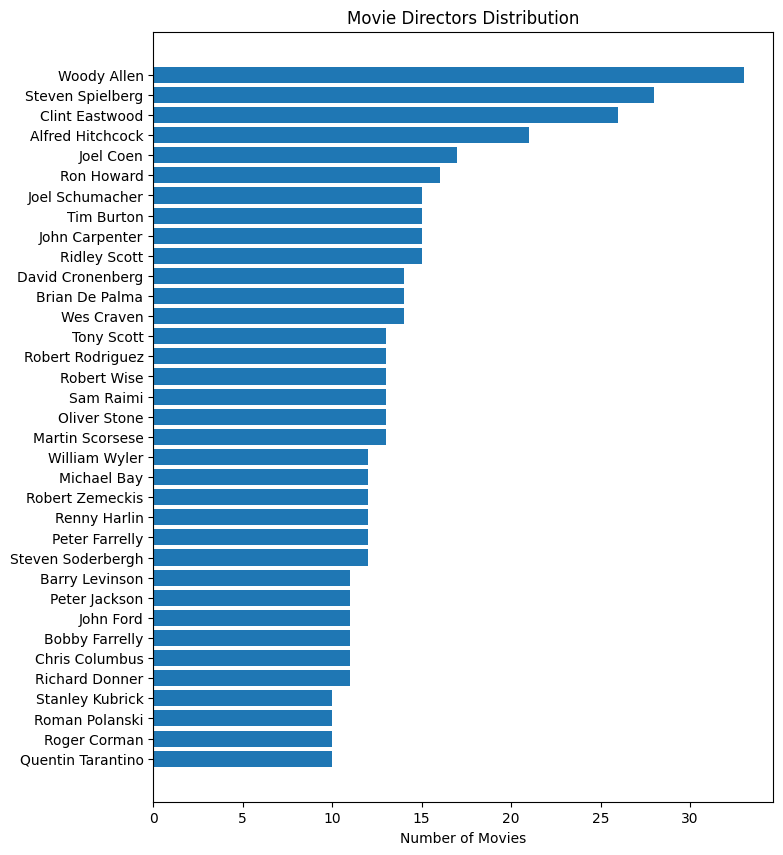

In [1288]:
director_counts = np.sum(director_features, axis=0)
director_features_df = pd.DataFrame({'director': director_features.columns.to_list(), 'count': director_counts}).sort_values(by="count")
director_features_df = director_features_df[director_features_df['count'] >= 10]
director_features_df = director_features_df.reset_index(drop=True)

plt.figure(figsize=(8, 10))
plt.barh(director_features_df['director'], director_features_df['count'])
plt.xlabel('Number of Movies')
plt.title('Movie Directors Distribution')
plt.show()

In [1289]:
# Retain only directors with 10 or more movies
director_features = director_features[director_features_df['director']]
print(f"Shape of dataset: {director_features.shape}")

Shape of dataset: (4026, 35)


In [1290]:
# Concatenate necessary feature before training the model
movie_metadata_encoded_df = pd.concat([genre_features, director_features, cast_features, movies_metadata_df[['roberta_sentiment_encoded', 'vote_average']]], axis=1)

print(f"Shape of dataset: {movies_metadata_df.shape}")
movie_metadata_encoded_df.head(5)

Shape of dataset: (4026, 13)


,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,John Goodman,Liam Neeson,Johnny Depp,Matt Damon,Willem Dafoe,Robert De Niro,Bruce Willis,Samuel L. Jackson,roberta_sentiment_encoded,vote_average
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,7.7
1,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2.0,6.9
2,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,2.0,7.7
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2.0,6.2
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,5.5


In [1291]:
# Standardized numerical features
scale = StandardScaler()
scaled_features = scale.fit_transform(movie_metadata_encoded_df)
scaled_features = pd.DataFrame(scaled_features, columns=movie_metadata_encoded_df.columns)

scaled_features.head(5)

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,John Goodman,Liam Neeson,Johnny Depp,Matt Damon,Willem Dafoe,Robert De Niro,Bruce Willis,Samuel L. Jackson,roberta_sentiment_encoded,vote_average
0,-0.562625,2.035132,4.677072,-0.250099,1.471426,-0.506125,-0.083687,-0.949604,-0.235764,-0.32471,...,-0.097614,-0.098903,-0.098903,-0.101433,-0.102675,-0.109847,-0.11327,-0.117688,1.125783,1.504519
1,1.777383,2.035132,-0.213809,-0.250099,-0.679613,-0.506125,-0.083687,-0.949604,4.241529,-0.32471,...,-0.097614,-0.098903,-0.098903,-0.101433,-0.102675,-0.109847,-0.11327,-0.117688,1.125783,0.552055
2,1.777383,-0.491369,-0.213809,-0.250099,-0.679613,1.975798,-0.083687,1.053071,-0.235764,-0.32471,...,-0.097614,-0.098903,-0.098903,-0.101433,-0.102675,9.103571,-0.11327,-0.117688,1.125783,1.504519
3,-0.562625,-0.491369,-0.213809,-0.250099,1.471426,-0.506125,-0.083687,1.053071,-0.235764,-0.32471,...,-0.097614,-0.098903,-0.098903,-0.101433,-0.102675,-0.109847,-0.11327,-0.117688,1.125783,-0.281351
4,1.777383,-0.491369,-0.213809,-0.250099,-0.679613,1.975798,-0.083687,-0.949604,-0.235764,-0.32471,...,-0.097614,-0.098903,-0.098903,-0.101433,-0.102675,-0.109847,-0.11327,-0.117688,-0.574931,-1.114757


## Model Creation

`NearestNeighbors` machine learning algorithm will be used to find data points closest to a specified input. This will be achieved by using the cosine similarity metric to assess the degree of similarity among the data points.

In [1292]:
model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute').fit(scaled_features)
print(model)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)


In [1293]:
# By specifying the parameter n_neighbors=11 in our model, it will produce 11 indices and distances corresponding to 
# movie that closely resemble the user input, which includes the input movie itself.
vg_distances, vg_indices = model.kneighbors(scaled_features)

print("List of indexes and distances for the first 5 games:\n")
print(vg_indices[:5], "\n")
print(vg_distances[:5])

List of indexes and distances for the first 5 games:

[[   0 3189  994 2783  703 3975  140  732  598 3324  878]
 [   1 2594  603  406   36 2679  328 1665 2253 2774  150]
 [   2  434 2369 1591 2257  440 1266 1996 2943  316  989]
 [   3 1069  656 3248 2256  429  464  507  439  460 1861]
 [   4 3851 3114 1988 3909   31 2630 2590 2746 3028 1094]] 

[[0.00000000e+00 4.49094766e-05 7.22801950e-04 2.90852517e-03
  1.13708726e-01 1.45020378e-01 1.51053706e-01 1.53598791e-01
  1.64977821e-01 1.73690407e-01 1.82479886e-01]
 [2.22044605e-16 4.98706142e-02 5.37294513e-02 1.23258991e-01
  1.24729201e-01 1.26800549e-01 1.44584601e-01 1.54987523e-01
  1.59104956e-01 1.73129687e-01 1.73426843e-01]
 [3.33066907e-16 2.06998489e-01 2.47779795e-01 2.58159277e-01
  2.63900570e-01 2.68205804e-01 2.83024909e-01 3.10711396e-01
  3.83029036e-01 3.87493710e-01 3.87661606e-01]
 [4.44089210e-16 2.85019025e-01 3.04369681e-01 3.11728327e-01
  3.17054976e-01 3.17512407e-01 3.30326886e-01 3.32833824e-01
  3.33700867e

In [1294]:
# Convert movie titles into vector representations utilizing the `TfidfVectorizer`
movie_names = movies_metadata_df['title'].drop_duplicates()
movie_names = movie_names.reset_index(drop=True)

vectorizer = TfidfVectorizer(use_idf=True).fit(movie_names)

movie_title_vectors = vectorizer.transform(movie_names)

print("List of title vectors for the first 5 movie:\n")
print(pd.DataFrame(movie_title_vectors.toarray()).head(5))

List of title vectors for the first 5 movie:

   0     1     2     3     4     5     6     7     8     9     ...  3977  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   3978  3979  3980  3981  3982  3983  3984  3985  3986  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 3987 columns]


In [1301]:

# NOTE: Need to save the content of the dataframe in csv
movies_metadata_recom = pd.DataFrame(movies_metadata_df).drop(columns=['imdb_id', 'roberta_sentiment_encoded'], axis=1)


def get_top_closest_movie_names(movie_name, top_n=5):
    '''
    This function will recommend movie titles that have the closest match to the input
    '''
    query_vector = vectorizer.transform([movie_name])
    similarity_scores = cosine_similarity(query_vector, movie_title_vectors)

    top_closest_match_idx = np.argsort(similarity_scores[0])[::-1][:top_n]
    top_closest_match_name = movie_names.loc[top_closest_match_idx.tolist()].values

    return top_closest_match_name


def get_movie_recommendation(movie_name, top_n=10):
    '''
    This function will provide movie recommendations based on various features of the given movie (input)
    '''
    movie_idx = movies_metadata_recom.query("title == @movie_name").index  
    
    if movie_idx.empty:
        # If the movie entered by the user doesn't exist in the records, the program will recommend a new movie similar to the input
        top_closest_match_name = get_top_closest_movie_names(movie_name=movie_name, top_n=5)

        print(f"'{movie_name}' doesn't exist in the records.\n")
        print(f"You may want to try the movies which are the closest match to the input.")

        for movie in top_closest_match_name.tolist():
            print(f"- {movie}")
    
    else:
        # Place in a separate dataframe the indices and distances, then sort the record by distance in ascending order       
        vg_combined_dist_idx_df = pd.DataFrame()
        for idx in movie_idx:
            vg_dist_idx_df = pd.concat([pd.DataFrame(vg_indices[idx]), pd.DataFrame(vg_distances[idx])], axis=1)
            vg_combined_dist_idx_df = pd.concat([vg_combined_dist_idx_df, vg_dist_idx_df])

        vg_combined_dist_idx_df = vg_combined_dist_idx_df.set_axis(['Index', 'Distance'], axis=1, inplace=False)
        vg_combined_dist_idx_df = vg_combined_dist_idx_df.reset_index(drop=True)
        vg_combined_dist_idx_df = vg_combined_dist_idx_df.sort_values(by='Distance', ascending=True)

        movie_list = movies_metadata_recom.iloc[vg_combined_dist_idx_df['Index']]

        # Remove any duplicate movie names to provide the user with a diverse selection of recommended movies
        movie_list = movie_list.drop_duplicates(subset=['title'], keep='first')
        
        # Remove from the list any game that shares the same name as the input
        movie_list = movie_list[movie_list['title'] != movie_name]

        # Get the first 10 games in the list
        recommended_movie_list = movie_list.head(top_n)

        # Get the distance of the movies similar to the input
        recommended_distances = np.array(vg_combined_dist_idx_df['Distance'].head(top_n))

        print(f"Top 10 Recommended Movies for '{movie_name}'")

        recommended_movie_list = recommended_movie_list.reset_index(drop=True)

        display(recommended_movie_list.style.hide_index().set_precision(1))

In [1302]:
get_movie_recommendation('Edward Scissor')

'Edward Scissor' doesn't exist in the records.

You may want to try the movies which are the closest match to the input.
- Edward Scissorhands
- Trolls
- Valentine
- Death Warrant
- Battle Beyond the Stars


In [1303]:
get_movie_recommendation('Lady and the Tramp')

Top 10 Recommended Movies for 'Lady and the Tramp'


title,release_year,genre,production_companies,cast,director,budget,revenue,runtime,vote_average,viwers_sentiment
The Sword in the Stone,1963,"['Animation', 'Adventure', 'Comedy']",['Walt Disney Productions'],"['Sebastian Cabot', 'Karl Swenson', 'Junius Matthews', 'Norman Alden', 'Rickie Sorensen', 'Ginny Tyler', 'Martha Wentworth', 'Alan Napier', 'Richard Reitherman', 'Robert Reitherman']",['Wolfgang Reitherman'],3000000.0,22182353.0,79.0,6.9,positive
Shaun the Sheep Movie,2015,"['Animation', 'Adventure', 'Comedy']","['Aardman Animations', 'Studio Canal', 'Anton Capital Entertainment (ACE)']","['Justin Fletcher', 'Omid Djalili', 'Richard Webber', 'Kate Harbour', 'Tim Hands', 'Simon Greenall', 'Andy Nyman', 'Emma Tate', 'Jack Paulson', 'Sean Connolly', 'Henry Burton', 'Dhimant Vyas', 'Sophie Laughton', 'Nia Medi James', 'Stanley Unwin', 'Nick Park', 'John Sparkes']","['Mark Burton', 'Richard Starzack']",0.0,59700000.0,85.0,6.9,positive
Robin Hood,1973,"['Animation', 'Adventure', 'Comedy']",['Walt Disney Productions'],"['Brian Bedford', 'Phil Harris', 'Peter Ustinov', 'Pat Buttram', 'Ken Curtis', 'George Lindsey', 'Barbara Luddy', 'Monica Evans', 'Carole Shelley', 'Andy Devine', 'Terry-Thomas', 'Billy Whitaker', 'John Fiedler', 'Sean Marshall', 'Roger Miller']",['Wolfgang Reitherman'],15000000.0,32056467.0,83.0,7.0,positive
The Road to El Dorado,2000,"['Animation', 'Adventure', 'Comedy']","['DreamWorks SKG', 'DreamWorks Animation']","['Kenneth Branagh', 'Kevin Kline', 'Rosie Perez', 'Armand Assante', 'Edward James Olmos', 'Jim Cummings', 'Frank Welker', 'Tobin Bell', 'Elton John', 'Duncan Marjoribanks', 'Elijah Chiang', 'Cyrus Shaki-Khan']","['Don Michael Paul', 'Bibo Bergeron']",95000000.0,76432727.0,89.0,7.0,positive
Despicable Me 2,2013,"['Animation', 'Adventure', 'Comedy']","['Universal Pictures', 'Illumination Entertainment']","['Steve Carell', 'Kristen Wiig', 'Benjamin Bratt', 'Miranda Cosgrove', 'Russell Brand', 'Ken Jeong', 'Steve Coogan', 'Elsie Kate Fisher', 'Dana Gaier', 'Moisés Arias', 'Nasim Pedrad', 'Kristen Schaal', 'Pierre Coffin', 'Chris Renaud', 'Nickolai Stoilov', 'Vanessa Bayer', 'Ava Acres', 'Lori Alan', 'Jack Angel', 'Eva Bella', 'Georgia Cook', 'John Cygan', 'Debi Derryberry', 'Jess Harnell', 'Danny Mann', 'Mona Marshall', 'Mickie McGowan', 'Mason McNulty', 'Alec Medlock', 'Laraine Newman', 'Jan Rabson', 'Andre Robinson', 'Katie Silverman', 'Casey Simpson', 'Claira Nicole Titman', 'Jim Ward', 'April Winchell', 'Bailey Gambertoglio', 'Sherry Lynn']","['Pierre Coffin', 'Chris Renaud']",76000000.0,970761885.0,98.0,7.0,positive
A Bug's Life,1998,"['Animation', 'Adventure', 'Comedy']","['Walt Disney Pictures', 'Pixar Animation Studios']","['Kevin Spacey', 'Julia Louis-Dreyfus', 'Hayden Panettiere', 'Phyllis Diller', 'Bonnie Hunt', 'Joe Ranft', 'Jonathan Harris', 'Madeline Kahn', 'Richard Kind', 'Denis Leary', 'Dave Foley', 'David Hyde Pierce', 'Michael McShane', 'John Ratzenberger', 'Brad Garrett', 'Roddy McDowall']",['John Lasseter'],120000000.0,363258859.0,95.0,6.8,positive
Bedknobs and Broomsticks,1971,"['Animation', 'Adventure', 'Comedy']",['Walt Disney Productions'],"['Angela Lansbury', 'David Tomlinson', 'Roddy McDowall', 'Sam Jaffe', 'John Ericson', 'Bruce Forsyth', 'Roy Snart', 'Ian Weighill', 'Arthur Gould-Porter', 'Ben Wrigley', 'Reginald Owen', 'Cyril Delevanti', 'Rick Traeger']",['Robert Stevenson'],20000000.0,17900000.0,117.0,6.8,positive
Wreck-It Ralph,2012,"['Animation', 'Adventure', 'Comedy']",['Walt Disney Animation Studios'],"['John C. Reilly', 'Sarah Silverman', 'Jack McBrayer', 'Jane Lynch', 'Alan Tudyk', 'Mindy Kaling', 'Joe Lo Truglio', 'Dennis Haysbert', 'Adam Carolla', 'Horatio Sanz', 'Rich Moore', 'Edie McClurg', 'Jess Harnell', 'Rachael Harris', 'Skylar Astin', 'Katie Lowes', 'Jamie Elman', 'Josie Trinidad', 'Cymbre Walk', 'Phil Johnston', 'Stefanie Scott', 'John DiMaggio', 'Raymond S. Persi', 'Brian Kesinger', 'Martin Jarvis', 'Tucker Gilmore', 'Brandon Scott', 'Tim Mertens', 'Maurice

## Group 3 Members
- Abhishek Natani
- Auradee Castro
- Bhumika Rajendra Babu
- Miraj Sinya
- Olivia Deguit 
- Rochan Mehta
- Roger Mais
- Varun Sharma 